In [6]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, Tokenizer
from pyspark.sql.functions import regexp_replace, lower, col, udf
from pyspark.sql.functions import split, size
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import spacy
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from gensim import corpora, models
import numpy as np

# Needed on RaaS
os.environ['PYSPARK_PYTHON'] = sys.executable

# Not needed
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [7]:
def init_spark():
  spark = SparkSession.builder.config("spark.driver.memory", "5g").\
                              appName("BigData").getOrCreate()
  
  sc = spark.sparkContext
  return spark, sc

## Preprocess dataset for training and testing.

In [3]:
def get_sample_from_file(file_name, output_file, sample_size = 10_000):
    """
    Reads a file and extracts a sample of lines from it.
    
    Parameters:
    file_name (str): The name of the input file.
    output_file (str): The name of the output file where the sample will be written.
    sample_size (int): The number of lines to extract from the input file. Default is 10,000.
    """
    
    content = ""
    with open(file_name, "r") as f:
        for i in range(sample_size):
            content += f.readline()

    with open(output_file, "w") as f:
        f.write(content)

In [8]:
def load_data_from_json(spark, file_name):
    return spark.read.json(file_name)

### Initialize Context and Load Sample

In [4]:
# Generate a sample from the input file
get_sample_from_file("data.json", "arxiv-sample.json")

NameError: name 'get_sample_from_file' is not defined

In [9]:
sc = init_spark()[0]
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

## Clean dataset

### Searcing for missing values

In [7]:
# search for missing values
print("Number of missing values in abstract column: ", arxiv_dataset.filter(arxiv_dataset.abstract.isNull()).count())
print("Number of missing values in title column: ", arxiv_dataset.filter(arxiv_dataset.title.isNull()).count())
print("Number of missing values in categories column: ", arxiv_dataset.filter(arxiv_dataset.categories.isNull()).count())
print("Number of missing values in id column: ", arxiv_dataset.filter(arxiv_dataset.id.isNull()).count())
print("Number of missing values in submitter column: ", arxiv_dataset.filter(arxiv_dataset.submitter.isNull()).count())
print("Number of missing values in authors column: ", arxiv_dataset.filter(arxiv_dataset.authors.isNull()).count())
print("Number of missing values in report-no column: ",arxiv_dataset.filter(arxiv_dataset["report-no"].isNull()).count() )
print("Number of missing values in comments column: ", arxiv_dataset.filter(arxiv_dataset.comments.isNull()).count())
print("Number of missing values in doi column: ", arxiv_dataset.filter(arxiv_dataset.doi.isNull()).count())
print("Number of missing values in journal-ref column: ", arxiv_dataset.filter(arxiv_dataset["journal-ref"].isNull()).count())
print("Number of missing values in versions column: ", arxiv_dataset.filter(arxiv_dataset.versions.isNull()).count())


Number of missing values in abstract column:  0
Number of missing values in title column:  0
Number of missing values in categories column:  0
Number of missing values in id column:  0
Number of missing values in submitter column:  0
Number of missing values in authors column:  0
Number of missing values in report-no column:  9118
Number of missing values in comments column:  1138
Number of missing values in doi column:  3641
Number of missing values in journal-ref column:  4571
Number of missing values in versions column:  0


In [8]:
# show rows with empty fields
arxiv_dataset.filter(arxiv_dataset["abstract"] == "").count()
arxiv_dataset.filter(arxiv_dataset["title"] == "").count()
arxiv_dataset.filter(arxiv_dataset["authors"] == "").count()
arxiv_dataset.filter(arxiv_dataset["categories"] == "").count()

0

### Basic preprocessing functions

In [13]:
# fill ALL NULL values with empty string : use after removing rows with empty fields
def fill_na_with_empty_string(df):
    return df.fillna("")

# remove rows with empty fields
def remove_empty_fields(df, field_name):
    return df.filter(df[field_name] != "")

# remove "\n" from text
def remove_empty_newlines(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\n", " "))

# remove math formulas and latex
def remove_math_formula(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\$.*?\$", ""))

# convert to lowercase
def convert_to_lowercase(df, field_name):
    return df.withColumn(field_name, lower(col(field_name)))

# remove extra spaces
def remove_extra_spaces(df, field_name):
    df = df.withColumn(field_name, regexp_replace(col(field_name), " +", " "))
    df = df.withColumn(field_name, regexp_replace(col(field_name), "^ +", ""))
    return df

# remove punctuation
def remove_punctuation(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "[^\w\s]", ""))


### Clear 'abstract' column

In [10]:
arxiv_dataset = remove_empty_fields(arxiv_dataset, "abstract")
arxiv_dataset = remove_empty_newlines(arxiv_dataset, "abstract")
arxiv_dataset = remove_math_formula(arxiv_dataset, "abstract")
arxiv_dataset = convert_to_lowercase(arxiv_dataset, "abstract")
arxiv_dataset = remove_extra_spaces(arxiv_dataset, "abstract")

In [11]:
# Show some changed rows
arxiv_dataset.select("abstract").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract       

## Convert Abstract to Vector Representation

In [12]:
# create a Word2Vec model
input_col = "abstract"
output_col = "abstract_vector"

words2vec_model = Word2Vec(
    inputCol="words",
    outputCol=output_col,
    vectorSize=100,
    minCount=5
)

tokenized = Tokenizer(inputCol=input_col, outputCol="words")
tokenized_dataset = tokenized.transform(arxiv_dataset)
model = words2vec_model.fit(tokenized_dataset)

In [13]:
model.getVectors().show(n=2, truncate=False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Vizualize most popular categories based on how many authors contributed to that category

In [14]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [15]:
@udf(returnType=ArrayType(StringType()))
def get_authors_list(parsed_authors):
    authors = [
        f"{author[0]} {author[1]}" for author in parsed_authors
    ]
    return authors

arxiv_dataset = arxiv_dataset.withColumn("authors_list", get_authors_list("authors_parsed"))

In [16]:
arxiv_dataset.select("authors_list").show(5, truncate=False)

+------------------------------------------------------+
|authors_list                                          |
+------------------------------------------------------+
|[Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]|
|[Streinu Ileana, Theran Louis]                        |
|[Pan Hongjun]                                         |
|[Callan David]                                        |
|[Abu-Shammala Wael, Torchinsky Alberto]               |
+------------------------------------------------------+
only showing top 5 rows



In [17]:
# preprocess authors column : remove the "and" word and split the authors by comma
def preprocess_authors(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " and ", ", "))

# preprocess authors column : remove extra commas
def remove_authors_extra_commas(df):
    return df.withColumn("authors", regexp_replace(col("authors"), ",+", ","))
    
# preprocess authors column : remove empty spaces (more than one space)
def remove_authors_extra_spaces(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " +", " "))

# preprocess authors column : remove parentheses and their content
def remove_authors_parentheses(df):
    return df.withColumn("authors", regexp_replace(col("authors"), "\(.+?\)", ""))
    

In [18]:
arxiv_dataset = preprocess_authors(arxiv_dataset)
arxiv_dataset = remove_authors_extra_commas(arxiv_dataset)
arxiv_dataset = remove_authors_extra_spaces(arxiv_dataset)

In [54]:
# see the first 5 rows
arxiv_dataset.select("authors_list").show(5, truncate=False)

+------------------------------------------------------+
|authors_list                                          |
+------------------------------------------------------+
|[Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]|
|[Streinu Ileana, Theran Louis]                        |
|[Pan Hongjun]                                         |
|[Callan David]                                        |
|[Abu-Shammala Wael, Torchinsky Alberto]               |
+------------------------------------------------------+
only showing top 5 rows



In [47]:
# Get all categories
categories = arxiv_dataset.select("categories")

categories = (
    categories.rdd.map(lambda x: x.categories)
    .map(lambda x: x.split(" "))
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

print("Number of categories: ", categories.count())

# Get all authors
authors = arxiv_dataset.select("authors_list")
authors = (
    authors.rdd.map(lambda x: x.authors_list)
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

print("Number of authors: ", authors.count())

# get all authors for each category

categories_authors = {}
auth_categories = arxiv_dataset.select("categories", "authors_list")
categories_authors = (
    auth_categories.rdd.map(lambda x: (x.categories, x.authors_list))
    .map(lambda x: (x[0].split(" "), x[1]))
    .flatMap(lambda x: [(item, x[1]) for item in x[0]])
    .reduceByKey(lambda x, y: x + y)
    .map(lambda x: (x[0], list(set(x[1]))))
)

# categories_authors to dict
categories_authors = dict(categories_authors.collect())

# get number of authors for each category
count_authors = {}
for category in categories_authors:
    count_authors[category] = len(categories_authors[category])

# sort categories based on number of authors
sorted_categories = sorted(count_authors.items(), key=lambda x: x[1], reverse=True)

# get top 10 categories
top_categories = sorted_categories[:10]

Number of categories:  142
Number of authors:  24626


In [46]:
top_categories

[('astro-ph', 7385),
 ('hep-ph', 2064),
 ('hep-th', 1863),
 ('cond-mat.mtrl-sci', 1584),
 ('quant-ph', 1522),
 ('cond-mat.str-el', 1447),
 ('cond-mat.mes-hall', 1141),
 ('nucl-ex', 1106),
 ('gr-qc', 1092),
 ('cond-mat.stat-mech', 990)]

### Topic extraction and stats (most popular topic per category)

BERTopic? Gensim? LDA?

In [ ]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [48]:
# https://arxiv.org/help/api/user-manual
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

#### Display the distribution of categories
- the categories are mostly 1 to 2 per paper

In [51]:
categories_length = arxiv_dataset.select(size(split(arxiv_dataset.categories, " ")).alias("categories_length"))

In [53]:
# print max, min, and average number of categories
maxim = categories_length.agg({"categories_length": "max"}).collect()[0][0]
minim = categories_length.agg({"categories_length": "min"}).collect()[0][0]
avg = categories_length.agg({"categories_length": "mean"}).collect()[0][0]
std = categories_length.agg({"categories_length": "std"}).collect()[0][0]
median = categories_length.agg({"categories_length": "median"}).collect()[0][0]

print("Max number of categories: ", maxim)
print("Min number of categories: ", minim)
print("Average number of categories: ", avg)
print("Standard deviation of categories: ", std)
print("Median number of categories: ", median)

Max number of categories:  9
Min number of categories:  1
Average number of categories:  1.5062
Standard deviation of categories:  0.8074817413887864
Median number of categories:  1.0


(array([6.389e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.563e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.510e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.250e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.900e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.600e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

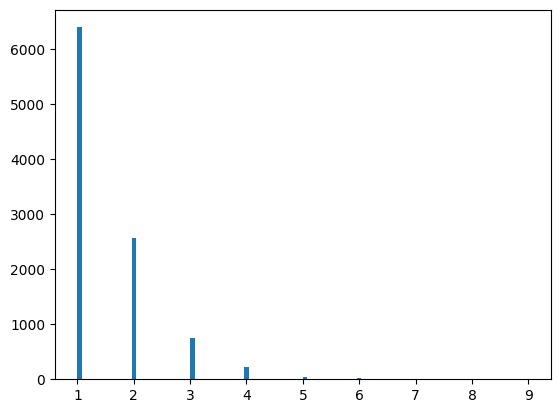

In [57]:
categories_length_list  = map(lambda row: row.categories_length, categories_length.collect())
plt.hist(list(categories_length_list), bins=100)

#### Most/Least popular category 

In [58]:
# most frequently occuring category
categories = arxiv_dataset.select("categories").collect()
categories = [row.categories for row in categories]
categories = [cat.split(" ") for cat in categories]
categories = [item for sublist in categories for item in sublist]

# most frequently occuring category
print( 
    "Most frequently occuring category: ", 
    max(set(categories), key = categories.count), 
    " (", categories.count(max(set(categories), key = categories.count)), " times)"
)

# least frequently occuring category
print( 
    "Least frequently occuring category: ", 
    min(set(categories), key = categories.count), 
    " (", categories.count(min(set(categories), key = categories.count)), " times)"
)

Most frequently occuring category:  astro-ph  ( 2064  times)
Least frequently occuring category:  astro-ph.EP  ( 1  times)


#### Analyzing the abstracts

In [59]:
# abstract length (histogram)
abstract_lengths = arxiv_dataset.select(size(split("abstract", " ")).alias('abstract_lengths'))

In [60]:
max_length = abstract_lengths.agg({"abstract_lengths": "max"}).collect()[0][0]
min_length = abstract_lengths.agg({"abstract_lengths": "min"}).collect()[0][0]
avg_length = abstract_lengths.agg({"abstract_lengths": "mean"}).collect()[0][0]
std_length = abstract_lengths.agg({"abstract_lengths": "std"}).collect()[0][0]
median_length = abstract_lengths.agg({"abstract_lengths": "median"}).collect()[0][0]

# In number of words
print("Max length of abstract: ", max_length)
print("Min length of abstract: ", min_length)
print("Average length of abstract: ", avg_length)
print("Standard deviation of abstract length: ", std_length)
print("Median length of abstract: ", median_length)

Max length of abstract:  317
Min length of abstract:  4
Average length of abstract:  113.5268
Standard deviation of abstract length:  58.025032289497474
Median length of abstract:  102.0


(array([  2.,  15.,  17.,  33.,  49.,  52.,  61.,  96.,  83., 115., 102.,
        111., 129., 148., 144., 246., 164., 180., 172., 206., 211., 242.,
        240., 357., 260., 244., 258., 239., 235., 240., 301., 206., 206.,
        225., 194., 197., 182., 166., 227., 150., 150., 143., 152., 133.,
        124., 129., 152., 118., 115.,  97.,  81.,  88.,  89., 104.,  68.,
         74.,  69.,  76.,  60.,  67.,  74.,  76.,  55.,  57.,  53.,  66.,
         49.,  44.,  36.,  59.,  59.,  54.,  48.,  45.,  50.,  36.,  48.,
         37.,  39.,  29.,  34.,  26.,  27.,  21.,  19.,  13.,  15.,   8.,
          6.,  10.,   2.,   6.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  4.  ,   7.13,  10.26,  13.39,  16.52,  19.65,  22.78,  25.91,
         29.04,  32.17,  35.3 ,  38.43,  41.56,  44.69,  47.82,  50.95,
         54.08,  57.21,  60.34,  63.47,  66.6 ,  69.73,  72.86,  75.99,
         79.12,  82.25,  85.38,  88.51,  91.64,  94.77,  97.9 , 101.03,
        104.16, 107.29, 110.42

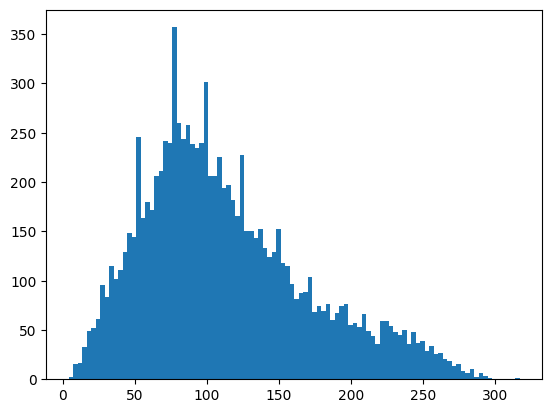

In [61]:
abstract_lengths_list = map(lambda row: row.abstract_lengths, abstract_lengths.collect())

plt.hist(list(abstract_lengths_list), bins=100)

### LDA preparations

In [93]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cezar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cezar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [94]:
# after some research : spacy is a bit faster than nltk on large datasets
def lemmatization(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

In [32]:
nlp = spacy.load('en_core_web_sm')

In [33]:
@udf(returnType=StringType())
def lemmatization_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [34]:
@udf(returnType=StringType())
def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [35]:
@udf(returnType=StringType())
def remove_punctuation(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_punct])

In [36]:
@udf(returnType=StringType())
def convert_to_lowercase(text):
    return text.lower()

In [100]:
# clear abstract column
arxiv_dataset = remove_empty_fields(arxiv_dataset, "abstract")
arxiv_dataset = remove_empty_newlines(arxiv_dataset, "abstract")
arxiv_dataset = remove_math_formula(arxiv_dataset, "abstract")
arxiv_dataset = remove_extra_spaces(arxiv_dataset, "abstract")
# convert to lowercase
arxiv_dataset = arxiv_dataset.withColumn("abstract", convert_to_lowercase("abstract"))
# remove punctuation
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_punctuation("abstract"))
# remove stopwords
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_stopwords("abstract"))

In [101]:
arxiv_dataset = arxiv_dataset.withColumn("abstract", lemmatization_spacy("abstract"))

### Gensim

In [64]:
abstracts = arxiv_dataset.select("abstract").rdd.map(lambda x: x.abstract.split()).collect()

['A', 'fully', 'differential', 'calculation', 'in', 'perturbative', 'quantum', 'chromodynamics', 'is', 'presented', 'for', 'the', 'production', 'of', 'massive', 'photon', 'pairs', 'at', 'hadron', 'colliders.', 'All', 'next-to-leading', 'order', 'perturbative', 'contributions', 'from', 'quark-antiquark,', 'gluon-(anti)quark,', 'and', 'gluon-gluon', 'subprocesses', 'are', 'included,', 'as', 'well', 'as', 'all-orders', 'resummation', 'of', 'initial-state', 'gluon', 'radiation', 'valid', 'at', 'next-to-next-to-leading', 'logarithmic', 'accuracy.', 'The', 'region', 'of', 'phase', 'space', 'is', 'specified', 'in', 'which', 'the', 'calculation', 'is', 'most', 'reliable.', 'Good', 'agreement', 'is', 'demonstrated', 'with', 'data', 'from', 'the', 'Fermilab', 'Tevatron,', 'and', 'predictions', 'are', 'made', 'for', 'more', 'detailed', 'tests', 'with', 'CDF', 'and', 'DO', 'data.', 'Predictions', 'are', 'shown', 'for', 'distributions', 'of', 'diphoton', 'pairs', 'produced', 'at', 'the', 'energy', 

In [68]:
dictionary = corpora.Dictionary(abstracts)
dictionary.filter_extremes(no_below=20, no_above=0.05)

In [69]:
dictionary.most_common(5)

[('emission', 935),
 ('spin', 878),
 ('star', 760),
 ('black', 758),
 ('X-ray', 756)]

In [70]:
corpus = [dictionary.doc2bow(text) for text in abstracts]

In [73]:
lda_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=100)

In [74]:
lda_model.print_topics()

[(0,
  '0.011*"decay" + 0.010*"production" + 0.008*"cross" + 0.006*"scattering" + 0.006*"nuclear" + 0.006*"detector" + 0.006*"neutrino" + 0.005*"decays" + 0.005*"measured" + 0.005*"measurements"'),
 (1,
  '0.008*"cosmological" + 0.008*"dark" + 0.006*"matter" + 0.005*"I" + 0.005*"dynamics" + 0.004*"scale" + 0.004*"simulations" + 0.004*"physical" + 0.004*"universe" + 0.004*"role"'),
 (2,
  '0.010*"group" + 0.006*"functions" + 0.006*"algebra" + 0.005*"complex" + 0.005*"type" + 0.005*"class" + 0.005*"certain" + 0.005*"proof" + 0.004*"positive" + 0.004*"Let"'),
 (3,
  '0.016*"symmetry" + 0.015*"Higgs" + 0.014*"gauge" + 0.010*"breaking" + 0.010*"topological" + 0.009*"masses" + 0.009*"scale" + 0.009*"neutrino" + 0.007*"mixing" + 0.007*"standard"'),
 (4,
  '0.011*"equations" + 0.009*"gauge" + 0.008*"solutions" + 0.006*"scalar" + 0.006*"string" + 0.006*"chiral" + 0.006*"theories" + 0.006*"theory." + 0.005*"action" + 0.005*"tensor"'),
 (5,
  '0.011*"transition" + 0.010*"critical" + 0.007*"spin" 

In [75]:
topics = [
    lda_model.get_document_topics(c)
    for c in corpus
]

In [76]:
topics[1]

[(2, 0.24761462), (7, 0.73014444)]

In [79]:
def most_probable_topic(t):
    t = np.array(t)
    idx = t[:, 1].argmax()
    return int(t[idx, 0])

final_topics = [most_probable_topic(t) for t in topics]

### Query for similar articles (based on the same topic/category/common authors/other criteria)

In [ ]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [80]:
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
words_data = tokenizer.transform(arxiv_dataset)

In [82]:
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashing_tf.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)

In [83]:
# Calculate TF-IDF similarity between articles
article_id = "0704.0001"  # Example article ID
article_tfidf = tfidf_data.filter(col("id") == article_id).select("features").first()["features"]
article_tfidf

SparseVector(1000, {9: 2.7937, 17: 0.1745, 22: 1.9864, 26: 3.0387, 63: 4.6255, 69: 2.9413, 80: 4.7787, 92: 2.7616, 113: 2.8185, 115: 2.8933, 133: 0.9823, 134: 9.6271, 147: 2.7505, 157: 1.527, 159: 2.593, 161: 2.8578, 162: 4.097, 168: 2.3882, 179: 2.0085, 188: 4.8346, 209: 1.1261, 226: 3.4398, 235: 2.0198, 253: 2.1638, 280: 2.7474, 282: 2.2673, 283: 3.0019, 289: 1.8503, 290: 3.0513, 304: 1.4913, 307: 1.8166, 311: 3.5864, 333: 1.7965, 335: 2.5971, 344: 1.4661, 351: 2.917, 353: 2.2799, 372: 0.0, 406: 2.1262, 413: 2.5171, 436: 3.2016, 439: 2.9115, 462: 3.4803, 467: 0.2604, 488: 0.1973, 490: 2.3158, 495: 0.1853, 510: 1.7893, 514: 3.2165, 535: 5.366, 575: 3.2755, 578: 2.6382, 591: 2.2037, 629: 2.01, 646: 3.6345, 650: 1.7756, 652: 3.1943, 653: 2.7521, 662: 2.8987, 663: 0.2806, 675: 3.51, 687: 3.2417, 695: 1.7255, 697: 2.7888, 718: 1.9612, 749: 1.7248, 759: 2.6354, 760: 0.4503, 763: 2.4644, 770: 2.223, 797: 2.9879, 804: 0.9008, 842: 3.1537, 843: 2.8631, 850: 2.9152, 855: 0.8729, 863: 3.3815, 8

In [84]:
article_id2 = "0704.0002"  # Example article ID
article_tfidf2 = tfidf_data.filter(col("id") == article_id2).select("features").first()["features"]
article_tfidf2

SparseVector(1000, {17: 0.0872, 24: 3.2041, 25: 2.8897, 55: 4.2258, 60: 1.5513, 85: 2.4397, 93: 3.5615, 125: 2.3817, 130: 1.4989, 133: 0.9823, 144: 3.316, 165: 2.5873, 181: 2.8613, 182: 2.408, 201: 5.2988, 212: 3.2417, 216: 2.8018, 221: 4.5116, 228: 1.9893, 241: 2.6942, 259: 3.142, 272: 1.3912, 274: 1.8031, 290: 6.1027, 296: 2.1708, 297: 5.834, 299: 1.5631, 310: 5.0946, 346: 2.6326, 372: 0.0, 377: 2.9376, 394: 2.1577, 425: 3.0945, 467: 0.651, 468: 1.5646, 488: 0.1973, 492: 2.6508, 495: 0.1853, 521: 2.616, 527: 2.1346, 581: 0.6502, 585: 5.6777, 588: 0.5146, 591: 2.2037, 601: 3.693, 613: 2.947, 636: 3.734, 650: 0.8878, 663: 0.4208, 686: 1.1935, 705: 3.2265, 719: 6.4886, 736: 0.6273, 760: 0.4503, 783: 2.0876, 784: 3.3525, 785: 3.1056, 791: 3.1034, 792: 2.3744, 828: 2.564, 846: 2.906, 870: 2.8185, 871: 2.144, 884: 3.0858, 885: 2.1355, 889: 1.8252, 891: 1.0487, 904: 3.8267, 935: 2.6839, 971: 8.3996, 975: 8.6475, 982: 3.51, 987: 3.1191})

In [85]:
def cosine_similarity(a, b):
    return float(a.dot(b) / (a.norm(2) * b.norm(2)))

In [86]:
# calculate cosine similarity between article_id and other articles and sort them
similarity = tfidf_data.rdd.map(lambda x: (x.id, cosine_similarity(article_tfidf, x.features))).sortBy(lambda x: x[1], ascending=False)

In [87]:
similarity.take(10)

[('0704.0001', 0.9999999999999999),
 ('0705.0035', 0.3158517952866129),
 ('0706.0518', 0.27351676851108747),
 ('0704.1344', 0.25314024097273047),
 ('0705.3887', 0.24939255602324506),
 ('0704.1677', 0.24928594693946296),
 ('0705.2759', 0.2389668543153525),
 ('0705.1622', 0.23811259979760943),
 ('0705.3836', 0.23796792259432675),
 ('0704.0601', 0.23200991968502913)]

In [88]:
# take the second article from similarity list
article_id2 = similarity.take(2)[1][0]
article_id2

'0705.0035'

In [89]:
# get the information of the second article
arxiv_dataset.filter(arxiv_dataset.id == article_id2).select("title", "abstract", "authors", "categories").show(truncate=False)

+---------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------

In [90]:
# get the information of the first article
arxiv_dataset.filter(arxiv_dataset.id == article_id).select("title", "abstract", "authors", "categories").show(truncate=False)

+----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Classification (for a new article to determine its category)

### First approach:
- use TF-IDF to vectorize the abstracts and Tokeniezer to tokenize the abstracts
- use CountVectors ("document-term vectors") and regex tokenizer to tokenize the abstracts ( + remove stop words)

Models to use:
- Naive Bayes
- Logistic Regression
- Random Forest

Finally: use Cross-Validation -> try to tune the hyperparameters

In [37]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [38]:
# drop columns
drop_colums = ["authors_parsed", "authors_list", "comments", "doi", "journal-ref", "license", "report-no", "submitter", "title", "versions", "authors", "update_date"]
arxiv_dataset = arxiv_dataset.drop(*drop_colums)

In [39]:
arxiv_dataset.show(5)

+--------------------+---------------+---------+
|            abstract|     categories|       id|
+--------------------+---------------+---------+
|  A fully differe...|         hep-ph|0704.0001|
|  We describe a n...|  math.CO cs.CG|0704.0002|
|  The evolution o...| physics.gen-ph|0704.0003|
|  We show that a ...|        math.CO|0704.0004|
|  In this paper w...|math.CA math.FA|0704.0005|
+--------------------+---------------+---------+
only showing top 5 rows



In [40]:
# from the categories column, get the first category
arxiv_dataset = arxiv_dataset.withColumn("category", split("categories", " ")[0])
# drop the categories column
arxiv_dataset = arxiv_dataset.drop("categories")

In [41]:
arxiv_dataset.show(5)

+--------------------+---------+--------------+
|            abstract|       id|      category|
+--------------------+---------+--------------+
|  A fully differe...|0704.0001|        hep-ph|
|  We describe a n...|0704.0002|       math.CO|
|  The evolution o...|0704.0003|physics.gen-ph|
|  We show that a ...|0704.0004|       math.CO|
|  In this paper w...|0704.0005|       math.CA|
+--------------------+---------+--------------+
only showing top 5 rows



In [42]:
string_indexer = StringIndexer(inputCol="category", outputCol="label", handleInvalid="skip")
indexer_fitted = string_indexer.fit(arxiv_dataset)
labels = indexer_fitted.labels # retrieve labels in order to use them later
arxiv_dataset = indexer_fitted.transform(arxiv_dataset)

In [43]:
arxiv_dataset.show(5)

+--------------------+---------+--------------+-----+
|            abstract|       id|      category|label|
+--------------------+---------+--------------+-----+
|  A fully differe...|0704.0001|        hep-ph|  2.0|
|  We describe a n...|0704.0002|       math.CO| 20.0|
|  The evolution o...|0704.0003|physics.gen-ph| 21.0|
|  We show that a ...|0704.0004|       math.CO| 20.0|
|  In this paper w...|0704.0005|       math.CA| 29.0|
+--------------------+---------+--------------+-----+
only showing top 5 rows



In [44]:
# remove stopwords
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_stopwords("abstract"))
# convert to lowercase
arxiv_dataset = arxiv_dataset.withColumn("abstract", convert_to_lowercase("abstract"))
# remove punctuation
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_punctuation("abstract"))
# apply lemmatization
arxiv_dataset = arxiv_dataset.withColumn("abstract", lemmatization_spacy("abstract"))

### Prepare the models: Logistic Regression, Random Forest, Naive Bayes

In [15]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=30, regParam=0.3, elasticNetParam=0)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")

desired approach: prepare the training data and then use what model you want

In [46]:
# Define a pipeline with stages for tokenization, TF-IDF conversion, and Logistic Regression
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

# minDocFreq: remove sparse terms
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf])

# fit the pipeline
pipeline_model = pipeline.fit(arxiv_dataset)
dataset = pipeline_model.transform(arxiv_dataset)

# Split the data into training and testing sets
(training_data, testing_data) = dataset.randomSplit([0.8, 0.2], seed=123)

In [ ]:
testing_data.show(5)

In [47]:
model_lr = lr.fit(training_data)
model_rf = rf.fit(training_data)
model_nb = nb.fit(training_data)

In [113]:
# Make predictions on the testing data
predictions_lr = model_lr.transform(testing_data)
predictions_rf = model_rf.transform(testing_data)
predictions_nb = model_nb.transform(testing_data)

In [ ]:
# show predictions
predictions_lr.select("abstract", "label", "prediction").show(5)
predictions_rf.select("abstract", "label", "prediction").show(5)
predictions_nb.select("abstract", "label", "prediction").show(5)

In [117]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_nb = evaluator.evaluate(predictions_nb)

print("Accuracy of Logistic Regression: ", accuracy_lr)
print("Accuracy of Random Forest: ", accuracy_rf)
print("Accuracy of Naive Bayes: ", accuracy_nb)

Accuracy of Logistic Regression:  0.5010060362173038
Accuracy of Random Forest:  0.2067404426559356
Accuracy of Naive Bayes:  0.6262575452716298


## Use CountVectorizer instead of HashingTF and regexTokenizer instead of Tokenizer

In [10]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [11]:
# drop columns
drop_colums = ["authors_parsed", "authors_list", "comments", "doi", "journal-ref", "license", "report-no", "submitter", "title", "versions", "authors", "update_date"]
arxiv_dataset = arxiv_dataset.drop(*drop_colums)
# from the categories column, get the first category
arxiv_dataset = arxiv_dataset.withColumn("category", split("categories", " ")[0])
# drop the categories column
arxiv_dataset = arxiv_dataset.drop("categories")
string_indexer = StringIndexer(inputCol="category", outputCol="label", handleInvalid="skip")
indexer_fitted = string_indexer.fit(arxiv_dataset)
labels = indexer_fitted.labels # retrieve labels in order to use them later
arxiv_dataset = indexer_fitted.transform(arxiv_dataset)


In [12]:
regexTokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

# fit the pipeline
pipeline_fit = pipeline.fit(arxiv_dataset)
dataset = pipeline_fit.transform(arxiv_dataset)

In [13]:
# Split the data into training and testing sets
(training_data, testing_data) = dataset.randomSplit([0.8, 0.2], seed=123)

In [25]:
# Train the model
model_lr = lr.fit(training_data)
model_rf = rf.fit(training_data)
model_nb = nb.fit(training_data)

In [27]:
# Make predictions on the testing data
predictions_lr = model_lr.transform(testing_data)
predictions_rf = model_rf.transform(testing_data)
predictions_nb = model_nb.transform(testing_data)

In [28]:
# evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_nb = evaluator.evaluate(predictions_nb)

print("Accuracy of Logistic Regression: ", accuracy_lr)
print("Accuracy of Random Forest: ", accuracy_rf)
print("Accuracy of Naive Bayes: ", accuracy_nb)

Accuracy of Logistic Regression:  0.5477867203219315
Accuracy of Random Forest:  0.22887323943661972
Accuracy of Naive Bayes:  0.5638832997987927


# predict on a single abstract (new article)


In [ ]:
# predict on a single abstract from the testing data
prediction = model.transform(testing_data.filter(testing_data.id == "0704.1072"))

# take the probability array of the prediction
prediction.select("probability").show(truncate=False)
# convert the probability array to a list
list_prediction = prediction.select("probability").collect()[0][0].toArray().tolist()
print(list_prediction)
threshold = 0.2
for i in range(len(list_prediction)):
    if list_prediction[i] > threshold:
        print(labels[i])